In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

In [2]:
import numpy as np
import random
import cv2
import colorsys
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
overlay.load_model("yolov3_voc_tf.xmodel")

In [4]:
anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

In [5]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [6]:
num_classes = len(class_names)
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))
random.seed(0)
random.shuffle(colors)
random.seed(None)

In [7]:
def draw_boxes(image, boxes, scores, classes):
    _, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_h, image_w, _ = image.shape

    for i, bbox in enumerate(boxes):
        [top, left, bottom, right] = bbox
        width, height = right - left, bottom - top
        center_x, center_y = left + width*0.5, top + height*0.5
        score, class_index = scores[i], classes[i]
        label = '{}: {:.4f}'.format(class_names[class_index], score) 
        color = tuple([color/255 for color in colors[class_index]])
        ax.add_patch(Rectangle((center_x-250, center_y-200), width*0.1, height*0.1,
                               edgecolor=color, facecolor='none'))
        ax.annotate(label, (center_x, center_y), color=color, weight='bold', 
                    fontsize=12, ha='center', va='center')
    return ax

def letterbox_image(image, size):
    ih, iw, _ = image.shape
    w, h = size
    scale = min(w/iw, h/ih)
    print(scale)
    
    nw = int(iw*scale)
    nh = int(ih*scale)
    print(nw)
    print(nh)

    image = cv2.resize(image, (nw,nh), interpolation=cv2.INTER_LINEAR)
    new_image = np.ones((h,w,3), np.uint8) * 128
    h_start = (h-nh)//2
    w_start = (w-nw)//2
    new_image[h_start:h_start+nh, w_start:w_start+nw, :] = image
    return new_image

def pre_process(image, model_image_size):
    image = image[...,::-1]
    image_h, image_w, _ = image.shape
 
    if model_image_size != (None, None):
        assert model_image_size[0]%32 == 0, 'Multiples of 32 required'
        assert model_image_size[1]%32 == 0, 'Multiples of 32 required'
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        new_image_size = (image_w - (image_w % 32), image_h - (image_h % 32))
        boxed_image = letterbox_image(image, new_image_size)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) 	
    return image_data

def _get_feats(feats, anchors, num_classes, input_shape):
    num_anchors = len(anchors)
    anchors_tensor = np.reshape(np.array(anchors, dtype=np.float32), [1, 1, 1, num_anchors, 2])
    grid_size = np.shape(feats)[1:3]
    nu = num_classes + 5
    predictions = np.reshape(feats, [-1, grid_size[0], grid_size[1], num_anchors, nu])
    grid_y = np.tile(np.reshape(np.arange(grid_size[0]), [-1, 1, 1, 1]), [1, grid_size[1], 1, 1])
    grid_x = np.tile(np.reshape(np.arange(grid_size[1]), [1, -1, 1, 1]), [grid_size[0], 1, 1, 1])
    grid = np.concatenate([grid_x, grid_y], axis = -1)
    grid = np.array(grid, dtype=np.float32)

    box_xy = (1/(1+np.exp(-predictions[..., :2])) + grid) / np.array(grid_size[::-1], dtype=np.float32)
    box_wh = np.exp(predictions[..., 2:4]) * anchors_tensor / np.array(input_shape[::-1], dtype=np.float32)
    box_confidence = 1/(1+np.exp(-predictions[..., 4:5]))
    box_class_probs = 1/(1+np.exp(-predictions[..., 5:]))
    return box_xy, box_wh, box_confidence, box_class_probs

def correct_boxes(box_xy, box_wh, input_shape, image_shape):
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = np.array(input_shape, dtype = np.float32)
    image_shape = np.array(image_shape, dtype = np.float32)
    new_shape = np.around(image_shape * np.min(input_shape / image_shape))
    offset = (input_shape - new_shape) / 2. / input_shape
    scale = input_shape / new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes = np.concatenate([
        box_mins[..., 0:1],
        box_mins[..., 1:2],
        box_maxes[..., 0:1],
        box_maxes[..., 1:2]
    ], axis = -1)
    boxes *= np.concatenate([image_shape, image_shape], axis = -1)
    return boxes

def boxes_and_scores(feats, anchors, classes_num, input_shape, image_shape):
    box_xy, box_wh, box_confidence, box_class_probs = _get_feats(feats, anchors, classes_num, input_shape)
    boxes = correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = np.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = np.reshape(box_scores, [-1, classes_num])
    return boxes, box_scores

def nms_boxes(boxes, scores):
    """Suppress non-maximal boxes.
    # Arguments
        boxes: ndarray, boxes of objects.
        scores: ndarray, scores of objects.
    # Returns
        keep: ndarray, index of effective boxes.
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2-x1+1)*(y2-y1+1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w1 = np.maximum(0.0, xx2 - xx1 + 1)
        h1 = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w1 * h1

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= 0.55)[0]  # threshold
        order = order[inds + 1]

    return keep

def evaluate(yolo_outputs, image_shape, class_names, anchors):
    score_thresh = 0.2
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    boxes = []
    box_scores = []
    input_shape = np.shape(yolo_outputs[0])[1 : 3]
    input_shape = np.array(input_shape)*32

    for i in range(len(yolo_outputs)):
        _boxes, _box_scores = boxes_and_scores(
            yolo_outputs[i], anchors[anchor_mask[i]], len(class_names), 
            input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = np.concatenate(boxes, axis = 0)
    box_scores = np.concatenate(box_scores, axis = 0)

    mask = box_scores >= score_thresh
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(len(class_names)):
        class_boxes_np = boxes[mask[:, c]]
        class_box_scores_np = box_scores[:, c]
        class_box_scores_np = class_box_scores_np[mask[:, c]]
        nms_index_np = nms_boxes(class_boxes_np, class_box_scores_np) 
        class_boxes_np = class_boxes_np[nms_index_np]
        class_box_scores_np = class_box_scores_np[nms_index_np]
        classes_np = np.ones_like(class_box_scores_np, dtype = np.int32) * c
        boxes_.append(class_boxes_np)
        scores_.append(class_box_scores_np)
        classes_.append(classes_np)
    boxes_ = np.concatenate(boxes_, axis = 0)
    scores_ = np.concatenate(scores_, axis = 0)
    classes_ = np.concatenate(classes_, axis = 0)

    return boxes_, scores_, classes_

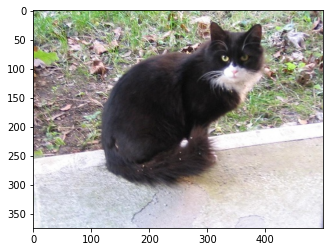

In [8]:
image_path = "demo.jpg"
image = cv2.imread(image_path)
_, ax = plt.subplots(1)
_ = ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [9]:
image_size = image.shape[:2]
image_data = np.array(pre_process(image, (416, 416)), dtype=np.float32)

0.832
416
312


In [10]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)

In [11]:
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]

In [12]:
input_data[0] = image_data
job_id = dpu.execute_async(input_data, output_data)
dpu.wait(job_id)

yolo_outputs = [np.array(output_data)]
boxes, scores, classes = evaluate(yolo_outputs, image_size, 
                                  class_names, anchors)

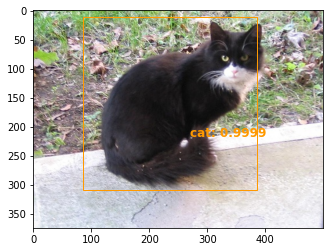

In [13]:
_ = draw_boxes(image, boxes, scores, classes)